In [1]:
# NOTES
# Run the jupyter notebook from the SPAUN base path.
# By default, I have commented out the code in run_spaun.py that simulates the network since that is not necessary
# for analysis. In addition, I have commented out the code that instantiates SPAUN modules other than
# the WorkingMemory module.

Number_of_gate_blocks = 0             # 1 for each memory block
Number_of_selector_blocks = 0         # 1 for each pair of (rehearsal,decay) memory blocks
Number_of_selection_nodes = 3         # Selector configured with 3 nodes
Number_of_Memory_blocks = 0           # 3 rehearsal, 3 decay, 1 mbave
Number_of_mbave_norm_subblocks = 0    # 1 norm memory block
Number_of_gate_sig_bias_subblocks = 0 # 1 gate signal bias block
Number_of_cnt_gate_sig_subblocks = 0  # 1 cnt gate signal bias block

Number_of_gated_inhibitors = 2        # 2 gated inhibitors

Taps_per_dimension = 8
Extra_inhibitory_taps = 4

# Number of dimensions in each semantic pointer
Semantic_Pointer_Dimensions = 2

def TAT_due_to_NE_Selector_block(sp_dims, num_sel_nodes, taps_per_dim, extra_inh_taps):
    return ((1*2*sp_dims + 2*3*sp_dims) + num_sel_nodes) * \
    (taps_per_dim / 2 * extra_inh_taps)
    
def TAT_due_to_E_Selector_block(sp_dims, taps_per_dim):
    return (3 * sp_dims + 1) * (taps_per_dim / 2)

def TAT_due_to_NE_Memory_block(sp_dims, num_gated_inh, taps_per_dim, extra_inh_taps):
    return num_gated_inh * (2 * sp_dims ) * (taps_per_dim / 2 * extra_inh_taps)


def TAT_due_to_E_Memory_block(sp_dims, num_gated_inh, taps_per_dim):
    return (3 + (num_gated_inh*(3+(3*sp_dims)))) * (taps_per_dim / 2)

def TAT_due_to_NE_Gate_block(sp_dims, taps_per_dim, extra_inh_taps):
    return sp_dims * (taps_per_dim / 2 * extra_inh_taps)

def TAT_due_to_E_Gate_block(sp_dims, taps_per_dim):
    return (sp_dims + 1) * (taps_per_dim / 2)

# The following function models the Selector block if it had at most 1 connection to a Ensembles
# neurons
def TAT_due_to_NE_Selector_block_rev_2(sp_dims, num_sel_nodes, taps_per_dim, extra_inh_taps):
    return ((1*1*sp_dims + 2*1*sp_dims) + num_sel_nodes) * \
    (taps_per_dim / 2 * extra_inh_taps)
    
%cd ..

/home/jjaguayo/spaun2.0_latest


# Introduction


This notebooks purpose is to use the structure of SPAUN's WorkingMemory module to determine the actual number of Tag Action Table (TAT) memory resources required for connections to Ensembles and connections to Ensemble's neurons as well as identify areas where required resource reduction might be possible.

The following table shows the TAT memory resources required to run SPAUN configured with 512 dimensional semantic pointer. The second column shows the total TAT resources required. The second columns number is broken down the third through sixth columns. The third column shows the TAT resources required due to connections to an Ensembles neurons. The fourth column shows the TAT resources required due to connections to an Ensemble. The fifth column shows the TAT resources required for Node to Node with identity transforms and either shared dimension fan-in connections or fan-out connections where the destination Node is non-local. Finally, the last column shows TAT resources required for Node to Node connections with non-identity transforms. 

|           |TAT total (Cores) | TAT - Nrn (Cores) | TAT - Enc (Cores) | TAT - Fan (Cores) | TAT - Mem (Cores) |	
|-----------|------------------|-------------------|-------------------|----------------------|-------------------|
| All modules             | <span style="background-color:yellow">1854945 (927.472) | <span style="background-color:yellow">1218816 (609.408) | <span style="background-color:yellow">271656 (135.828)| 94548 (47.274) | 269925 (134.963) |

We noticed that two-thirds of the total TAT resources required (first column) were due to a combination of connections to an Ensembles (third column) and connections to an Ensembles neurons (second column). 

Given the total TAT memory resources required, we tried to break down resources required by SPAUN modules. The following table shows the same type of data as table 1 above with each row representing resources required for a specific SPAUN module.  

|           |TAT total (Cores) | TAT - Nrn (Cores) | TAT - Enc (Cores) | TAT - Fan (Cores) | TAT - Mem (Cores) |	
|-----------|------------------|-------------------|-------------------|----------------------|-------------------|
|Vision only| 21160 (10.580)   | 6400 (3.200)      | 6652 (3.326)      | 800 (0.400)          | 7308 (3.654)      |
|ProductionSystem only | 153850 (76.925) | 98304 (49.152) | 24836 (12.418) | 6150 (3.075)      | 24560 (12.280)  |
|InformationEncoding only| 60996 (30.498) | 32768 (16.384) | 20540 (10.270) | 3074 (1.537)     | 4614 (2.307)    |
|<span style="background-color:yellow">WorkingMemory only| <span style="background-color:yellow">526642 (263.321) |<span style="background-color:yellow"> 335872 (167.936) |<span style="background-color:yellow"> 119024 (59.512) | 26638 (13.319)    | 45108 (22.554)  |
| TransformationSystem only| 229694 (114.847) | 114688 (57.344) | 53860 (26.930) | 7168 (3.584)| 53978 (26.989)  |
| InformationDecoding only| 110178 (55.089) | 34448 (17.224) | 21284 (10.642) | 4203 (2.102)   | 50243 (25.122)  |
| Motor System only       | 89 (0.044)      | 48 (0.024)     | 28 (0.014)     | 8 (0.004)      | 5 (0.003)       |

The problem with this breakdown was that the sum of each column did not add up to the values seen in the prior table. We presumed the reason was that when running the preprocessing and resource counting algorithms against each SPAUN module, resources required for connections between modules go uncounted, therefore each row is underestimating the TAT resources required. 

To confirm that the values are being underestimated, come up with better required resource estimates for a specific SPAUN module and determine whether we can reduce TAT resources required, we evaluated the WorkingMemory module. Although the contribution of this module may be underestimated, this module's contribution to TAT resources required is currently considered the largest. 

The following network diagram illustrates the top level structure of the WorkingMemory module.

![Top level view of the WorkingMemory module](./working_memory_module.png)

From this diagram, we see the module is composed of the following types of blocks:
* Nodes
    * Nodes are labelled MB1_Gate_Node, MB2_Gate_Node, MB3_Gate_Node, bias_node and num0_bias_node. They do not contribute to the TAT entries considered in this notebook. 
* Selector blocks
    * The Selector blocks labelled sel_mb1_in, sel_mb2_in and sel_mb3_in. 
* Memory blocks
    * The Memory blocks labelled MBAve, MB1A, MB1B, MB2A, MB2B, MB3A and MB3B.
* Gate blocks
    * The Gate blocks all labelled gate.
* "Signal" blocks
    * "Signal" blocks are labelled cnt_gate_sig, gate_sig_bias and mbave_norm. The structure of these blocks are simply an Ensemble connected to a Node. 

The following sections describe the structure of Selector, Memory and Gate blocks and provide a formula for determining the TAT resources required due to connections to Ensembles and connections to Ensemble's neurons.

We'll start by evaluating the Selector block, followed by the Memory and Gate blocks. The final section will combine the formulas for each block coming up with an equation for determining memory resources for the entire module.

# Evaluating Selector block

A Selector block has three input Nodes and three EnsembleArrays. Each EnsembleArray in SPAUN has 512-dimensional input and one sub-Ensemble per input dimension. 
 
The following network diagram was created with Nengo GUI and shows a single Selector block. The Selector block in this example has three selection Nodes and three EnsembleArrays configured with 2 dimensional inputs.
<img src="selector_block_2_dims.png">

The Nodes labelled in_node_0, in_node_1 and in_node_2 are not part of the Selector block and were added for illustration purposes. These Nodes are connected to the Selector blocks input Nodes labelled sel0, sel1 and sel2. The input Nodes then form connections to the EnsembleArrays sub-Ensembles as well as an Ensemble that labelled sel_none. 

By evaluating the SPAUN code that instantiates a Selector block as well as the network diagram above, we determine a formula to describe the TAT memory resources consumed by connections to Ensembles as well as connections to an Ensemble's Neurons. The formula tells us that the Selector block above should consume the following resources.

In [2]:
Number_of_selection_nodes = 3         # Selector configured with 3 nodes
Taps_per_dimension = 8
Extra_inhibitory_taps = 4

# Number of dimensions in each semantic pointer
Semantic_Pointer_Dimensions = 2

TAT_entries_due_to_NE_Selector_block = \
    TAT_due_to_NE_Selector_block(Semantic_Pointer_Dimensions, \
                                 Number_of_selection_nodes, \
                                 Taps_per_dimension, \
                                 Extra_inhibitory_taps)

TAT_entries_due_to_E_Selector_block = \
    TAT_due_to_E_Selector_block(Semantic_Pointer_Dimensions, \
                                Taps_per_dimension)

TAT_cores_due_to_NE_Selector_block = TAT_entries_due_to_NE_Selector_block / 2000.

TAT_cores_due_to_E_Selector_block = TAT_entries_due_to_E_Selector_block / 2000.

print 'TAT resources (cores) due to connections to Ensembles neurons = ',TAT_entries_due_to_NE_Selector_block,'(',TAT_cores_due_to_NE_Selector_block,')'
print 'TAT resources (cores) due to connections to Ensembles = ',TAT_entries_due_to_E_Selector_block,'(',TAT_cores_due_to_E_Selector_block,')'

TAT resources (cores) due to connections to Ensembles neurons =  304 ( 0.152 )
TAT resources (cores) due to connections to Ensembles =  28 ( 0.014 )


We can verify these numbers by first using SPAUN code to create a Selector block with 3 selections and 2 dimensional semantic pointers. The semantic pointer size is mentioned because the number of dimensions in each EnsembleArray is set equal to the semantic pointer dimensions. After creating the Selector block, we can preprocess the network using the nengo_brainstorm_pp modules preprocess function.

In [3]:
%%capture
%run run_spaun.py
cfg.sp_dim=2
model = nengo.Network()
with model:
    selector = cfg.make_selector(3,default_sel=0)
    in_node_0 = nengo.Node(output=1,label='in_node_0')
    in_node_1 = nengo.Node(output=1,label='in_node_1')
    in_node_2 = nengo.Node(output=1,label='in_node_2')
    nengo.Connection(in_node_0, selector.sel0)
    nengo.Connection(in_node_1, selector.sel1)
    nengo.Connection(in_node_2, selector.sel2)
model = pp.preprocess(model)


Finally, after creating and preprocessing the Selector block, we can count the resources consumed using the nengo_brainstorm_pp modules calc_core_cost function.

In [4]:
calc,info = pp.calc_core_cost(model,verbose=True)

neurons:               320 (     0.078 cores)
main mem entries:       20 (     0.000 cores)
accumulators:            1 (     0.001 cores)
tag action table:      351 (     0.175 cores)
  TAT - nrn     :      304 (     0.152 cores)
  TAT - enc     :       28 (     0.014 cores)


The values 'TAT - nrn' and 'TAT - enc' are equal to the TAT memory resources we calculated using our derived formulas. We verified the formulas against the preprocessing code and are able to determine how the semantic pointer dimensions affects the TAT entries needed.

Finally, we can plot the network using nengo_brainstorm modules gv_utils functions. The plot verifies that preprocessing creates multiple connections to Ensembles neurons. These connections can be combined reducing the TAT resources required for a Selector block. 

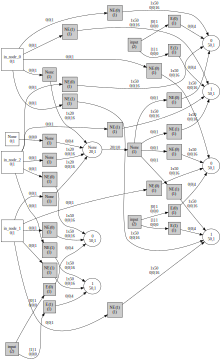

In [5]:
import nengo_brainstorm.gv_utils as gv
gv.gv_plot(model, extra_info=info)

# Evaluating Memory block

The following network diagram was created with Nengo GUI and shows a single Memory block. The Memory block has two input gated inhibitor circuits labelled mem1 and mem2. Each input gated inhibitor circuit has the same structure with three Ensembles, a bias Node and three EnsembleArrays. Each EnsembleArrays, in this example, has two input dimensions and thus two sub-Ensembles. In addition, two of the EnsembleArrays have sub-Ensembles whose neurons are connected to by external Ensembles. 
<img src="memory_block_2_dims.png">

The Nodes labelled in_node_0, in_node_1 and in_node_2 are not part of the Memory block and were added for illustration purposes. These nodes are connected to the Memory blocks input, gate and reset Nodes. 

By evaluating the SPAUN code that instantiates a Memory block as well as the network diagram above, we determine a formula to describe the TAT memory resources consumed by connections to Ensembles as well as to an Ensemble's Neurons. The formula tells us that the Memory block above should consume the following resources.

In [6]:
Number_of_gated_inhibitors = 2        # 2 gated inhibitors
Taps_per_dimension = 8
Extra_inhibitory_taps = 4

# Number of dimensions in each semantic pointer
Semantic_Pointer_Dimensions = 2


TAT_entries_due_to_NE_Memory_block = \
    TAT_due_to_NE_Memory_block(Semantic_Pointer_Dimensions, \
                               Number_of_gated_inhibitors, \
                               Taps_per_dimension, \
                               Extra_inhibitory_taps)

TAT_cores_due_to_NE_Memory_block = TAT_entries_due_to_NE_Memory_block / 2000.

TAT_entries_due_to_E_Memory_block = \
    TAT_due_to_E_Memory_block(Semantic_Pointer_Dimensions, \
                              Number_of_gated_inhibitors, \
                              Taps_per_dimension)
   
    
TAT_cores_due_to_E_Memory_block = TAT_entries_due_to_E_Memory_block / 2000.

print 'TAT resources (cores) due to connections to Ensembles neurons = ',TAT_entries_due_to_NE_Memory_block,'(',TAT_cores_due_to_NE_Memory_block,')'
print 'TAT resources (cores) due to connections to Ensembles = ',TAT_entries_due_to_E_Memory_block,'(',TAT_cores_due_to_E_Memory_block,')'

TAT resources (cores) due to connections to Ensembles neurons =  128 ( 0.064 )
TAT resources (cores) due to connections to Ensembles =  84 ( 0.042 )


We can verify these numbers by first using SPAUN code to create a Memory block with a reset_key of 0 and a semantic pointer input dimension size of 2. The semantic pointer size is mentioned because the number of dimensions in each EnsembleArray is set equal to the semantic pointer dimensions. After creating the Memory block, we can preprocess the network using the nengo_brainstorm_pp modules preprocess function.

In [7]:
%%capture
%run run_spaun.py
cfg.sp_dim=2
model = nengo.Network()
with model:
    memory_block = cfg.make_mem_block(vocab=vocab, reset_key=0)
    in_node_0 = nengo.Node(output=1,label='in_node_0')
    in_node_1 = nengo.Node(output=(1,1),label='in_node_1')
    in_node_2 = nengo.Node(output=1, label='in_node_2')
    nengo.Connection(in_node_0, memory_block.gate)
    nengo.Connection(in_node_1, memory_block.input)
    nengo.Connection(in_node_2, memory_block.reset)
model = pp.preprocess(model)

Finally, after creating and preprocessing the Memory block, we can count the resources consumed using the nengo_brainstorm_pp modules calc_core_cost function.

In [8]:
calc,info = pp.calc_core_cost(model,verbose=True)

neurons:              1050 (     0.256 cores)
main mem entries:     1079 (     0.017 cores)
accumulators:           38 (     0.038 cores)
tag action table:      243 (     0.121 cores)
  TAT - nrn     :      128 (     0.064 cores)
  TAT - enc     :       84 (     0.042 cores)


The values 'TAT - nrn' and 'TAT - enc' are equal to the TAT memory resources we calculated using our derived formulas. We verified the formulas against the preprocessing code and are able to determine how the semantic pointer dimensions affects the TAT entries needed.

Finally, we can plot the network using nengo_brainstorm modules gv_utils functions. Although it's hard to see, the plot verifies that preprocessing DOES NOT create multiple connections to Ensembles neurons nor should it. Prior to preprocessing, we can see from the network diagram above that any connection to an Ensembles neurons is not shared and therefore, after preprocessing, there will be no connection that shares a dimension from a Node to an Ensembles neurons.

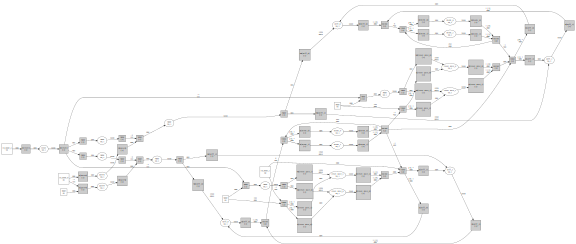

In [9]:
import nengo_brainstorm.gv_utils as gv
gv.gv_plot(model, extra_info=info)

# Evaluating Gate block

The following network diagram shows a Gate block. The block consists of an EnsembleArray and an Ensemble with connections to the EnsembleArray's sub-Ensemble's neurons. In this example, the EnsembleArray was configured with 2 dimensional input.
<img src="gate_block_2_dims.png">

The Node labelled in_node_0 is not part of the Gate block and was added for illustration purposes. This Node is connected to the Gate blocks Ensemble labelled gate. 

By evaluating the SPAUN code that instantiates a Gate block as well as the network diagram above, we determine a formula to describe the TAT memory resources consumed by connections to Ensembles as well as connections to an Ensemble's Neurons. The formula tells us that the Gate block above should consume the following resources.

In [10]:
Taps_per_dimension = 8
Extra_inhibitory_taps = 4

# Number of dimensions in each semantic pointer
Semantic_Pointer_Dimensions = 2


TAT_entries_due_to_NE_Gate_block = \
    TAT_due_to_NE_Gate_block(Semantic_Pointer_Dimensions, \
                               Taps_per_dimension, \
                               Extra_inhibitory_taps)
    
TAT_cores_due_to_NE_Gate_block = TAT_entries_due_to_NE_Gate_block / 2000.

TAT_entries_due_to_E_Gate_block = \
    TAT_due_to_E_Gate_block(Semantic_Pointer_Dimensions, \
                               Taps_per_dimension)
    
TAT_cores_due_to_E_Gate_block = TAT_entries_due_to_E_Gate_block / 2000.

print 'TAT resources (cores) due to connections to Ensembles neurons = ',TAT_entries_due_to_NE_Gate_block,'(',TAT_cores_due_to_NE_Gate_block,')'
print 'TAT resources (cores) due to connections to Ensembles = ',TAT_entries_due_to_E_Gate_block,'(',TAT_cores_due_to_E_Gate_block,')'

TAT resources (cores) due to connections to Ensembles neurons =  32 ( 0.016 )
TAT resources (cores) due to connections to Ensembles =  12 ( 0.006 )


We can verify these numbers by first using SPAUN code to create a Gate block with a semantic pointer input dimension size of 2. The semantic pointer size is mentioned because the number of dimensions in each EnsembleArray is set equal to the semantic pointer dimensions. After creating the Gate block, we can preprocess the network using the nengo_brainstorm_pp modules preprocess function.

In [11]:
%%capture
%run run_spaun.py
cfg.sp_dim=2
model = nengo.Network()
with model:
    ensemble_array_gate = cfg.make_ens_array_gate()
    in_node_0 = nengo.Node(output=1, label='in_node_0')
    nengo.Connection(in_node_0, ensemble_array_gate.gate)
model = pp.preprocess(model)

Finally, after creating and preprocessing the Gate block, we can count the resources consumed using the nengo_brainstorm_pp modules calc_core_cost function.

In [12]:
calc,info = pp.calc_core_cost(model,verbose=True)

neurons:               150 (     0.037 cores)
main mem entries:       50 (     0.001 cores)
accumulators:            1 (     0.001 cores)
tag action table:       46 (     0.023 cores)
  TAT - nrn     :       32 (     0.016 cores)
  TAT - enc     :       12 (     0.006 cores)


The values 'TAT - nrn' and 'TAT - enc' are equal to the TAT memory resources we calculated using our derived formulas. We verified the formulas against the preprocessing code and are able to determine how the semantic pointer dimensions affects the TAT entries needed.

Finally, we can plot the network using nengo_brainstorm modules gv_utils functions. The plot verifies that preprocessing DOES NOT create multiple connections to Ensembles neurons nor should it. Prior to preprocessing, we can see from the network diagram above that any connection to an Ensembles neurons is not shared and therefore, after preprocessing, there will be no connection that shares a dimension to an Ensembles neurons.

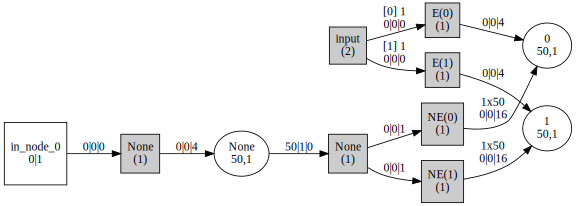

In [13]:
import nengo_brainstorm.gv_utils as gv
gv.gv_plot(model, extra_info=info)

# Evaluating WorkingMemory module

Now that we understand how to calculate TAT memory resources for the Gate, Memory and Selector block, we can determine the TAT resources for the entire module. Assuming a module with 512 dimensional semantic pointers, the TAT resources consumed by this module are as follows.

In [14]:
Number_of_gate_blocks = 7             # 1 for each memory block
Number_of_selector_blocks = 3         # 1 for each pair of (rehearsal,decay) memory blocks
Number_of_selection_nodes = 3         # Selector configured with 3 nodes
Number_of_Memory_blocks = 7           # 3 rehearsal, 3 decay, 1 mbave
Number_of_mbave_norm_subblocks = 1    # 1 norm memory block
Number_of_gate_sig_bias_subblocks = 1 # 1 gate signal bias block
Number_of_cnt_gate_sig_subblocks = 1  # 1 cnt gate signal bias block

Number_of_gated_inhibitors = 2        # 2 gated inhibitors

Taps_per_dimension = 8
Extra_inhibitory_taps = 4

# Number of dimensions in each semantic pointer
Semantic_Pointer_Dimensions = 512

TAT_entries_due_to_NE_Selector_block = \
    TAT_due_to_NE_Selector_block(Semantic_Pointer_Dimensions, \
                                 Number_of_selection_nodes, \
                                 Taps_per_dimension, \
                                 Extra_inhibitory_taps)

TAT_entries_due_to_NE_Memory_block = \
    TAT_due_to_NE_Memory_block(Semantic_Pointer_Dimensions, \
                               Number_of_gated_inhibitors, \
                               Taps_per_dimension, \
                               Extra_inhibitory_taps)

TAT_entries_due_to_NE_Gate_block = \
    TAT_due_to_NE_Gate_block(Semantic_Pointer_Dimensions, \
                               Taps_per_dimension, \
                               Extra_inhibitory_taps)

TAT_entries_due_to_NeuronEncoderNodes = \
    (Number_of_gate_blocks * TAT_entries_due_to_NE_Gate_block) + \
     (Number_of_selector_blocks *  TAT_entries_due_to_NE_Selector_block ) + \
     (Number_of_Memory_blocks * TAT_entries_due_to_NE_Memory_block)
    
TAT_cores_due_to_NeuronEncoderNodes = TAT_entries_due_to_NeuronEncoderNodes / 2000.

TAT_entries_due_to_E_Selector_block = \
    TAT_due_to_E_Selector_block(Semantic_Pointer_Dimensions, \
                                Taps_per_dimension)
TAT_entries_due_to_E_Memory_block = \
    TAT_due_to_E_Memory_block(Semantic_Pointer_Dimensions, \
                              Number_of_gated_inhibitors, \
                              Taps_per_dimension)

TAT_entries_due_to_E_Gate_block = \
    TAT_due_to_E_Gate_block(Semantic_Pointer_Dimensions, \
                               Taps_per_dimension)
TAT_entries_due_to_EncoderNodes = \
    (Number_of_gate_blocks*TAT_entries_due_to_E_Gate_block) + \
      (Number_of_selector_blocks * TAT_entries_due_to_E_Selector_block) + \
      (Number_of_Memory_blocks * TAT_entries_due_to_E_Memory_block) + \
      ((Number_of_gate_sig_bias_subblocks) + \
      (Number_of_cnt_gate_sig_subblocks) +
      (Number_of_mbave_norm_subblocks)) * \
        (Taps_per_dimension / 2)

TAT_cores_due_to_EncoderNodes = TAT_entries_due_to_EncoderNodes / 2000.
print 'TAT resources (cores) due to connections to Ensembles neurons = ',TAT_entries_due_to_NeuronEncoderNodes,'(',TAT_cores_due_to_NeuronEncoderNodes,')'
print 'TAT resources (cores) due to connections to Ensembles = ',TAT_entries_due_to_EncoderNodes,'(',TAT_cores_due_to_EncoderNodes,')'

TAT resources (cores) due to connections to Ensembles neurons =  483472 ( 241.736 )
TAT resources (cores) due to connections to Ensembles =  119088 ( 59.544 )


Comparing these numbers to the data in table 2 row 4, we see that, for this module, TAT resources due to connections from Nodes to Ensemble's neurons is higher (241.7 as opposed to 167.9 cores). The TAT resources due to connections from Nodes to Ensembles, however, is roughly the same.

# Restructuring Selector block

An obvious improvement for the WorkingMemory module would be to combine connections from Nodes to Ensembles neurons. Given what we know about the structure of the WorkingMemory module, this would only affect the Selector module reducing the TAT resources as follows.

In [15]:
Number_of_gate_blocks = 7             # 1 for each memory block
Number_of_selector_blocks = 3         # 1 for each pair of (rehearsal,decay) memory blocks
Number_of_selection_nodes = 3         # Selector configured with 3 nodes
Number_of_Memory_blocks = 7           # 3 rehearsal, 3 decay, 1 mbave
Number_of_mbave_norm_subblocks = 1    # 1 norm memory block
Number_of_gate_sig_bias_subblocks = 1 # 1 gate signal bias block
Number_of_cnt_gate_sig_subblocks = 1  # 1 cnt gate signal bias block

Number_of_gated_inhibitors = 2        # 2 gated inhibitors

Taps_per_dimension = 8
Extra_inhibitory_taps = 4

# Number of dimensions in each semantic pointer
Semantic_Pointer_Dimensions = 512



TAT_entries_due_to_NE_Selector_block = \
    TAT_due_to_NE_Selector_block_rev_2(Semantic_Pointer_Dimensions, \
                                 Number_of_selection_nodes, \
                                 Taps_per_dimension, \
                                 Extra_inhibitory_taps)

TAT_entries_due_to_NE_Memory_block = \
    TAT_due_to_NE_Memory_block(Semantic_Pointer_Dimensions, \
                               Number_of_gated_inhibitors, \
                               Taps_per_dimension, \
                               Extra_inhibitory_taps)

TAT_entries_due_to_NE_Gate_block = \
    TAT_due_to_NE_Gate_block(Semantic_Pointer_Dimensions, \
                               Taps_per_dimension, \
                               Extra_inhibitory_taps)

TAT_entries_due_to_NeuronEncoderNodes = \
    (Number_of_gate_blocks * TAT_entries_due_to_NE_Gate_block) + \
     (Number_of_selector_blocks * TAT_entries_due_to_NE_Selector_block) + \
     (Number_of_Memory_blocks * TAT_entries_due_to_NE_Memory_block)

TAT_cores_due_to_NeuronEncoderNodes = TAT_entries_due_to_NeuronEncoderNodes / 2000.

TAT_entries_due_to_E_Selector_block = \
    TAT_due_to_E_Selector_block(Semantic_Pointer_Dimensions, \
                                Taps_per_dimension)
TAT_entries_due_to_E_Memory_block = \
    TAT_due_to_E_Memory_block(Semantic_Pointer_Dimensions, \
                              Number_of_gated_inhibitors, \
                              Taps_per_dimension)

TAT_entries_due_to_E_Gate_block = \
    TAT_due_to_E_Gate_block(Semantic_Pointer_Dimensions, \
                               Taps_per_dimension)

TAT_entries_due_to_EncoderNodes = \
    (Number_of_gate_blocks*TAT_entries_due_to_E_Gate_block) + \
      (Number_of_selector_blocks * TAT_entries_due_to_E_Selector_block) + \
      (Number_of_Memory_blocks * TAT_entries_due_to_E_Memory_block) + \
      ((Number_of_gate_sig_bias_subblocks) + \
      (Number_of_cnt_gate_sig_subblocks) +
      (Number_of_mbave_norm_subblocks)) * \
        (Taps_per_dimension / 2)

TAT_cores_due_to_EncoderNodes = TAT_entries_due_to_EncoderNodes / 2000.
print 'TAT resources (cores) due to connections to Ensembles neurons = ',TAT_entries_due_to_NeuronEncoderNodes,'(',TAT_cores_due_to_NeuronEncoderNodes,')'
print 'TAT resources (cores) due to connections to Ensembles = ',TAT_entries_due_to_EncoderNodes,'(',TAT_cores_due_to_EncoderNodes,')'

TAT resources (cores) due to connections to Ensembles neurons =  360592 ( 180.296 )
TAT resources (cores) due to connections to Ensembles =  119088 ( 59.544 )


The TAT resources for connections to Ensemble Neurons is reduced from 241 cores to 180 cores.